# compare the performance of emulator configurations based on iter-0 samples
- SSE: Single-Site Emulator
- SBE: Similarity-Based Emulator
- LSE: Large-Sample Emulator

Methods: 
- GPR: Gaussian Process Regression
- RF: Random Forest
- MLP: Multilayer Perceptron Neural Network

In [1]:
import sys, os, glob, pickle, toml, json, pickle, random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import multiprocessing


sys.path.append('../../MOASMO_support')
from MOASMO_parameter_allbasin_emulator import *

In [2]:
# load data function, taken from ~/CTSM_repos/CTSM_calibration/src/MOASMO_support/MOASMO_parameter_allbasin_emulator.py
def load_basin_data():
    infile_basin_info = f"/glade/work/guoqiang/CTSM_CAMELS/data_mesh_surf/HillslopeHydrology/CAMELS_level1_basin_info.csv"
    infile_param_info = '/glade/u/home/guoqiang/CTSM_repos/CTSM_calibration/src/parameter/CTSM_CAMELS_SA_param_240202.csv'
    infile_attr_foruse = '/glade/u/home/guoqiang/CTSM_repos/CTSM_calibration/data/camels_attributes_table_TrainModel.csv'
    inpath_moasmo = "/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO_bigrange"
    path_CTSM_case = f'/glade/work/guoqiang/CTSM_CAMELS/Calib_HH_MOASMO_bigrange'
    iterend = 1 # only read data from iter-0

    outpath = f"{inpath_moasmo}/allbasin_emulator"
    os.makedirs(outpath, exist_ok=True)
    
    # Load data: same for all iterations
    df_basin_info = pd.read_csv(infile_basin_info)
    df_param_info = pd.read_csv(infile_param_info)
    
    file_defa_param = f'{outpath}/camels_627basin_ctsm_defa_param.csv'
    df_param_defa = read_allbasin_defa_params(path_CTSM_case, infile_param_info, file_defa_param, len(df_basin_info))

    file_param_lb = f'{outpath}/camels_627basin_ctsm_all_param_lb.gz'
    file_param_ub = f'{outpath}/camels_627basin_ctsm_all_param_ub.gz'
    df_param_lb, df_param_ub = load_basin_param_bounds(inpath_moasmo, df_param_defa, file_param_lb, file_param_ub)

    file_camels_attribute = f'{outpath}/camels_627basin_attribute.pkl'
    df_att = read_camels_attributes(infile_basin_info, file_camels_attribute)
    
    df_att_foruse = pd.read_csv(infile_attr_foruse)
    useattrs = list(df_att_foruse[df_att_foruse['att_Xie2021'].values]['Attribute_text'].values)
    print("The number of attributes used:", len(useattrs))
    print(useattrs)

    # Load data: outputs from each iteration
    for iter in range(0, iterend):
        file_all_param = f'{outpath}/camels_627basin_ctsm_all_param_iter{iter}.gz'
        file_all_metric = f'{outpath}/camels_627basin_ctsm_all_metric_iter{iter}.gz'
        file_all_basinid = f'{outpath}/camels_627basin_ctsm_all_basinid_iter{iter}.gz'
        
        df_param_i, df_metric_i, df_basinid_i = load_all_basin_params_metrics(inpath_moasmo, df_param_defa, df_basin_info, iter, file_all_param, file_all_metric, file_all_basinid)
        
        df_basinid_i['iter'] = iter
        
        if iter == 0:
            df_param = df_param_i
            df_metric = df_metric_i
            df_basinid = df_basinid_i
        else:
            df_param = pd.concat([df_param, df_param_i])
            df_metric = pd.concat([df_metric, df_metric_i])
            df_basinid = pd.concat([df_basinid, df_basinid_i])
    
    df_param.index = np.arange(len(df_param))
    df_metric.index = np.arange(len(df_metric))
    df_basinid.index = np.arange(len(df_basinid))

    index = np.isnan(np.sum(df_metric.values, axis=1))
    df_param = df_param[~index]
    df_metric = df_metric[~index]
    df_basinid = df_basinid[~index]
    
    df_param.index = np.arange(len(df_param))
    df_metric.index = np.arange(len(df_metric))
    df_basinid.index = np.arange(len(df_basinid))
    
    print('Number of nan samples:', np.sum(index))
    print("Number of original parameter sets:", len(index))
    print("Number of final parameter sets:", len(df_param))

    return df_basin_info, df_param_info, df_param_defa, df_param_lb, df_param_ub, df_att, df_att_foruse, df_param, df_metric, df_basinid

In [3]:
def evaluate_cv(cv_results):
    # evaluation
    rmse_test = np.nan * np.zeros(len(cv_results))
    rmse_train = np.nan * np.zeros(len(cv_results))
    cc_test = np.nan * np.zeros(len(cv_results))
    cc_train = np.nan * np.zeros(len(cv_results))
    
    for fold in range(1, len(cv_results)+1):
        y_train, y_test, y_train_pred, y_test_pred = cv_results[fold]['y_train'], cv_results[fold]['y_test'], cv_results[fold]['y_train_pred'], cv_results[fold]['y_test_pred']
        
        # Evaluate the model using 
        rmse_test[fold - 1] = get_rmse(y_test, y_test_pred)
        rmse_train[fold - 1] = get_rmse(y_train, y_train_pred)
        cc_test[fold - 1] = get_cc(y_test, y_test_pred)
        cc_train[fold - 1] = get_cc(y_train, y_train_pred)
            
    return rmse_test, rmse_train, cc_test, cc_train


def get_rmse(d1, d2):
    return ( np.nanmean( (d1-d2)**2 ) ) ** 0.5

def get_cc(d1, d2):
    ind = ~np.isnan(d1+d2)
    return np.corrcoef(d1[ind], d2[ind])[0,1]


# Load data and save data for model training and comparison
Here I just load the outputs from LSE which has summarized outputs from individual basins

In [4]:
# inpath = '/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO_bigrange/allbasin_emulator'

# file_all_param = f'{inpath}/camels_627basin_ctsm_all_param_iter0.gz'
# file_all_metric = f'{inpath}/camels_627basin_ctsm_all_meric_iter0.gz'
# file_all_basinid = f'{inpath}/camels_627basin_ctsm_all_basinid_iter0.gz'

# df_param = pd.read_csv(file_all_param, compression='gzip')
# df_metric = pd.read_csv(file_all_metric, compression='gzip')
# df_basinid = pd.read_csv(file_all_basinid, compression='gzip')

df_basin_info, df_param_info, df_param_defa, df_param_lb, df_param_ub, df_att, df_att_foruse, df_param, df_metric, df_basinid = load_basin_data()
print('Number of basins:', len(df_basin_info))
print('Number of all parameters:', len(df_param_info))
print('Number of all attributes:', len(df_att.columns))

File exists: /glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO_bigrange/allbasin_emulator/camels_627basin_attribute.pkl
The number of attributes used: 27
['mean_elev', 'mean_slope', 'area_gauges2', 'p_mean', 'pet_mean', 'aridity', 'p_seasonality', 'frac_snow', 'high_prec_freq', 'high_prec_dur', 'low_prec_freq', 'low_prec_dur', 'frac_forest', 'lai_max', 'lai_diff', 'dom_land_cover', 'dom_land_cover_frac', 'soil_depth_pelletier', 'soil_depth_statsgo', 'soil_porosity', 'soil_conductivity', 'max_water_content', 'sand_frac', 'silt_frac', 'clay_frac', 'carbonate_rocks_frac', 'geol_permeability']
Number of nan samples: 3309
Number of original parameter sets: 250800
Number of final parameter sets: 247491
Number of basins: 627
Number of all parameters: 27
Number of all attributes: 62


In [5]:
inpath_moasmo = '/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO_bigrange'
outpath_all = f'{inpath_moasmo}/LargeSampleEmulator_exps_out'
os.makedirs(outpath_all, exist_ok=True)
numbasin = len(df_basin_info)

In [6]:
num_cpus = 1  # Example: Use 4 CPUs

# SSE train and CV

## Train/Evaluate GPR model

In [7]:
# serial version

# from sklearn.model_selection import KFold
# from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

# path_MOASMO = '/glade/u/home/guoqiang/CTSM_repos/ctsm_optz/MO-ASMO/src/'
# sys.path.append(path_MOASMO)
# import sampling
# import gp
# import NSGA2

# def gpr_emulator_cv(x, y, xlb_mean, xub_mean, rndseed=1234567890):
    
#     random.seed(rndseed)
#     np.random.seed(rndseed)

#     n_splits = 5
#     alpha = 1e-3
#     leng_lb = 1e-3
#     leng_ub = 1e3
#     nu = 2.5

#     cv_results = {}
        
#     kf = KFold(n_splits=n_splits, shuffle=True) 
#     kge_scores = np.nan * np.zeros([n_splits, y.shape[1]])
    
#     for fold_idx, (train_index, test_index) in enumerate(kf.split(x), 1):
#         x_train, x_test = x[train_index], x[test_index]
#         y_train, y_test = y[train_index], y[test_index]
        
#         # Initialize and train your GPR model here; adjust parameters as needed
#         sm = gp.GPR_Matern(x_train, y_train, x_train.shape[1], y_train.shape[1], x_train.shape[0], xlb_mean, xub_mean, alpha=alpha, leng_sb=[leng_lb, leng_ub], nu=nu)

#         # Store results
#         cv_results[fold_idx] = {
#                 # 'model': bp_model,  # Optional: Comment this out to avoid large serialization
#                 'train_index': train_index,
#                 'test_index': test_index,
#                 'y_train': np.squeeze(y_train),
#                 'y_test': np.squeeze(y_test),
#                 'y_test_pred': np.squeeze(sm.predict(x_test)),
#                 'y_train_pred': np.squeeze(sm.predict(x_train)),
#             }

#     return cv_results


# outfile = f'{outpath_all}/SSE_GPR_normKGE_CV_estimates.pkl'

# # if os.path.isfile(outfile):
# if False:
#     with open(outfile, 'rb') as file:
#         gpr_cv_results = pickle.load(file)
    
# else:
#     gpr_cv_results = []
#     for i in range(2):
#         indi = df_basinid['basin_id'].values == i
#         kgei = df_metric[indi]['kge'].values
#         kgei = kgei / (2 - kgei)
#         parami = df_param[indi].values
    
#         # only select useful params
#         lbi = df_param_lb.iloc[i].values
#         ubi = df_param_ub.iloc[i].values
#         induse = lbi != ubi
#         parami = parami[:, induse]
#         lbi = lbi[induse]
#         ubi = ubi[induse]
    
#         metrics_use = kgei[:,np.newaxis]
        
#         cv_results = gpr_emulator_cv(parami, metrics_use, lbi, ubi)
#         gpr_cv_results.append(cv_results)

#     with open(outfile, 'wb') as file:
#         pickle.dump(gpr_cv_results, file)

In [8]:
%%time

# Parallel version

from sklearn.model_selection import KFold

path_MOASMO = '/glade/u/home/guoqiang/CTSM_repos/ctsm_optz/MO-ASMO/src/'
sys.path.append(path_MOASMO)
import sampling
import gp
import NSGA2

def gpr_emulator_cv(x, y, xlb_mean, xub_mean, rndseed=1234567890):
    
    random.seed(rndseed)
    np.random.seed(rndseed)

    n_splits = 5
    alpha = 1e-3
    leng_lb = 1e-3
    leng_ub = 1e3
    nu = 2.5

    cv_results = {}
        
    kf = KFold(n_splits=n_splits, shuffle=True) 
    kge_scores = np.nan * np.zeros([n_splits, y.shape[1]])
    
    for fold_idx, (train_index, test_index) in enumerate(kf.split(x), 1):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Initialize and train your GPR model here; adjust parameters as needed
        sm = gp.GPR_Matern(x_train, y_train, x_train.shape[1], y_train.shape[1], x_train.shape[0], xlb_mean, xub_mean, alpha=alpha, leng_sb=[leng_lb, leng_ub], nu=nu)

        # Store results
        cv_results[fold_idx] = {
                'train_index': train_index,
                'test_index': test_index,
                'y_train': np.squeeze(y_train),
                'y_test': np.squeeze(y_test),
                'y_test_pred': np.squeeze(sm.predict(x_test)),
                'y_train_pred': np.squeeze(sm.predict(x_train)),
            }

    return cv_results

def process_basin(i):
    indi = df_basinid['basin_id'].values == i
    kgei = df_metric[indi]['kge'].values
    kgei = kgei / (2 - kgei)
    parami = df_param[indi].values

    # only select useful params
    lbi = df_param_lb.iloc[i].values
    ubi = df_param_ub.iloc[i].values
    induse = lbi != ubi
    parami = parami[:, induse]
    lbi = lbi[induse]
    ubi = ubi[induse]

    metrics_use = kgei[:, np.newaxis]

    cv_results = gpr_emulator_cv(parami, metrics_use, lbi, ubi)
    return cv_results

outfile = f'{outpath_all}/SSE_GPR_normKGE_CV_estimates.pkl'

if os.path.isfile(outfile):
    with open(outfile, 'rb') as file:
        gpr_cv_results = pickle.load(file)
else:

    with multiprocessing.Pool(processes=num_cpus) as pool:
        gpr_cv_results = pool.map(process_basin, range(numbasin))

    with open(outfile, 'wb') as file:
        pickle.dump(gpr_cv_results, file)

CPU times: user 44.6 ms, sys: 16.3 ms, total: 60.9 ms
Wall time: 100 ms


In [9]:
%%time

# evaluate GPR CV


outfile = f'{outpath_all}/SSE_GPR_normKGE_CV_evaluation.npz'

if os.path.isfile(outfile):
    dtmp = np.load(outfile)
    gpr_rmse_train = dtmp['gpr_rmse_train']
    gpr_rmse_test = dtmp['gpr_rmse_test']
    gpr_cc_train = dtmp['gpr_cc_train']
    gpr_cc_test = dtmp['gpr_cc_test']

else:

    gpr_rmse_train = np.nan * np.zeros([numbasin, 5])
    gpr_rmse_test = np.nan * np.zeros([numbasin, 5])
    gpr_cc_train = np.nan * np.zeros([numbasin, 5])
    gpr_cc_test = np.nan * np.zeros([numbasin, 5])    
    for i in range(len(gpr_cv_results)):
        gpr_rmse_test[i, :], gpr_rmse_train[i, :], gpr_cc_test[i, :], gpr_cc_train[i, :] = evaluate_cv(gpr_cv_results[i])

    np.savez_compressed(outfile, gpr_rmse_train=gpr_rmse_train, gpr_rmse_test=gpr_rmse_test, gpr_cc_train=gpr_cc_train, gpr_cc_test=gpr_cc_test)

CPU times: user 3.43 ms, sys: 0 ns, total: 3.43 ms
Wall time: 30.4 ms


## Train/Evalute RF model

In [10]:
%%time

# Parallel version

from sklearn.model_selection import KFold


def rf_emulator_cv(x, y, xlb_mean, xub_mean):

    random.seed(1234567890)
    np.random.seed(1234567890)
    
    n_splits = 5

    cv_results = {}
    kf = KFold(n_splits=n_splits, shuffle=True) 
    kge_scores = np.nan * np.zeros([n_splits, y.shape[1]])


    # normalize
    x = (x - xlb_mean) / (xub_mean - xlb_mean)

    
    for fold_idx, (train_index, test_index) in enumerate(kf.split(x), 1):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Initialize and train your GPR model here; adjust parameters as needed
        sm = RandomForestRegressor()
        sm.fit(x_train, y_train)
        
        # Store results
        cv_results[fold_idx] = {
                'train_index': train_index,
                'test_index': test_index,
                'y_train': np.squeeze(y_train),
                'y_test': np.squeeze(y_test),
                'y_test_pred': np.squeeze(sm.predict(x_test)),
                'y_train_pred': np.squeeze(sm.predict(x_train)),
            }

    return cv_results


def process_basin(i):
    indi = df_basinid['basin_id'].values == i
    kgei = df_metric[indi]['kge'].values
    kgei = kgei / (2 - kgei)
    parami = df_param[indi].values

    # only select useful params
    lbi = df_param_lb.iloc[i].values
    ubi = df_param_ub.iloc[i].values
    induse = lbi != ubi
    parami = parami[:, induse]
    lbi = lbi[induse]
    ubi = ubi[induse]

    metrics_use = kgei[:, np.newaxis]

    cv_results = rf_emulator_cv(parami, metrics_use, lbi, ubi)
    return cv_results

outfile = f'{outpath_all}/SSE_RF_normKGE_CV_estimates.pkl'

if os.path.isfile(outfile):
    with open(outfile, 'rb') as file:
        rf_cv_results = pickle.load(file)
else:

    with multiprocessing.Pool(processes=num_cpus) as pool:
        rf_cv_results = pool.map(process_basin, range(numbasin))

    with open(outfile, 'wb') as file:
        pickle.dump(rf_cv_results, file)

CPU times: user 47.8 ms, sys: 17.2 ms, total: 65 ms
Wall time: 258 ms


In [11]:
# evaluate
outfile = f'{outpath_all}/SSE_RF_normKGE_CV_evaluation.npz'

if os.path.isfile(outfile):
    dtmp = np.load(outfile)
    rf_rmse_train = dtmp['rf_rmse_train']
    rf_rmse_test = dtmp['rf_rmse_test']
    rf_cc_train = dtmp['rf_cc_train']
    rf_cc_test = dtmp['rf_cc_test']

else:

    rf_rmse_train = np.nan * np.zeros([numbasin, 5])
    rf_rmse_test = np.nan * np.zeros([numbasin, 5])
    rf_cc_train = np.nan * np.zeros([numbasin, 5])
    rf_cc_test = np.nan * np.zeros([numbasin, 5])    
    for i in range(len(rf_cv_results)):
        rf_rmse_test[i, :], rf_rmse_train[i, :], rf_cc_test[i, :], rf_cc_train[i, :] = evaluate_cv(rf_cv_results[i])

    np.savez_compressed(outfile, rf_rmse_train=rf_rmse_train, rf_rmse_test=rf_rmse_test, rf_cc_train=rf_cc_train, rf_cc_test=rf_cc_test)

## Train/Evaluate MLP model

In [14]:
%%time

# Parallel version
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold


def mlp_emulator_cv(x, y, xlb_mean, xub_mean):

    random.seed(1234567890)
    np.random.seed(1234567890)
    
    n_splits = 5

    cv_results = {}
    kf = KFold(n_splits=n_splits, shuffle=True) 
    kge_scores = np.nan * np.zeros([n_splits, y.shape[1]])


    # normalize
    x = (x - xlb_mean) / (xub_mean - xlb_mean)

    for fold_idx, (train_index, test_index) in enumerate(kf.split(x), 1):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Initialize and train your GPR model here; adjust parameters as needed
        # sm = make_pipeline(StandardScaler(), MLPRegressor(hidden_layer_sizes=(2000,)))
        sm = make_pipeline(StandardScaler(), MLPRegressor(hidden_layer_sizes=(2000,),  alpha=0.9))
        sm.fit(x_train, y_train)

        # Store results
        cv_results[fold_idx] = {
                'train_index': train_index,
                'test_index': test_index,
                'y_train': np.squeeze(y_train),
                'y_test': np.squeeze(y_test),
                'y_test_pred': np.squeeze(sm.predict(x_test)),
                'y_train_pred': np.squeeze(sm.predict(x_train)),
            }

    return cv_results


def process_basin(i):
    indi = df_basinid['basin_id'].values == i
    kgei = df_metric[indi]['kge'].values
    kgei = kgei / (2 - kgei)
    parami = df_param[indi].values

    # only select useful params
    lbi = df_param_lb.iloc[i].values
    ubi = df_param_ub.iloc[i].values
    induse = lbi != ubi
    parami = parami[:, induse]
    lbi = lbi[induse]
    ubi = ubi[induse]

    metrics_use = kgei[:, np.newaxis]

    cv_results = mlp_emulator_cv(parami, metrics_use, lbi, ubi)
    return cv_results

outfile = f'{outpath_all}/SSE_MLP_normKGE_CV_estimates.pkl'

if os.path.isfile(outfile):
    with open(outfile, 'rb') as file:
        mlp_cv_results = pickle.load(file)
else:

    with multiprocessing.Pool(processes=num_cpus) as pool:
        mlp_cv_results = pool.map(process_basin, range(numbasin))

    with open(outfile, 'wb') as file:
        pickle.dump(mlp_cv_results, file)

CPU times: user 50.4 ms, sys: 28 ms, total: 78.3 ms
Wall time: 111 ms


In [15]:
# evaluate
outfile = f'{outpath_all}/SSE_MLP_normKGE_CV_evaluation.npz'

if os.path.isfile(outfile):
    dtmp = np.load(outfile)
    mlp_rmse_train = dtmp['mlp_rmse_train']
    mlp_rmse_test = dtmp['mlp_rmse_test']
    mlp_cc_train = dtmp['mlp_cc_train']
    mlp_cc_test = dtmp['mlp_cc_test']

else:

    mlp_rmse_train = np.nan * np.zeros([numbasin, 5])
    mlp_rmse_test = np.nan * np.zeros([numbasin, 5])
    mlp_cc_train = np.nan * np.zeros([numbasin, 5])
    mlp_cc_test = np.nan * np.zeros([numbasin, 5])    
    for i in range(len(mlp_cv_results)):
        mlp_rmse_test[i, :], mlp_rmse_train[i, :], mlp_cc_test[i, :], mlp_cc_train[i, :] = evaluate_cv(mlp_cv_results[i])

    np.savez_compressed(outfile, mlp_rmse_train=mlp_rmse_train, mlp_rmse_test=mlp_rmse_test, mlp_cc_train=mlp_cc_train, mlp_cc_test=mlp_cc_test)

# Statistics

In [16]:
print('mean rmse train/test', np.nanmean(gpr_rmse_train), np.nanmean(gpr_rmse_test) )
print('mean cc train/test', np.nanmean(gpr_cc_train), np.nanmean(gpr_cc_test) )

mean rmse train/test 0.01602375177474596 0.07449462442358838
mean cc train/test 0.9717979920443841 0.7913423940296098


In [17]:
print('mean rmse train/test', np.nanmean(rf_rmse_train), np.nanmean(rf_rmse_test) )
print('mean cc train/test', np.nanmean(rf_cc_train), np.nanmean(rf_cc_test) )

mean rmse train/test 0.027107613013837416 0.07219663558870755
mean cc train/test 0.9838820472249656 0.8071012348527201


In [18]:
print('mean rmse train/test', np.nanmean(mlp_rmse_train), np.nanmean(mlp_rmse_test) )
print('mean cc train/test', np.nanmean(mlp_cc_train), np.nanmean(mlp_cc_test) )

mean rmse train/test 0.04896116147480786 0.07109251325483687
mean cc train/test 0.9175851974621652 0.8092091741775724


In [19]:
np.nanmedian(gpr_rmse_test), np.nanmedian(rf_rmse_test), np.nanmedian(mlp_rmse_test)

(0.05882821565184366, 0.061725544671725335, 0.06030343379000705)

ratio that gpr+rf is better than mlp 0.7400318979266348
ratio gpr is better than rf 0.5263157894736842
ratio gpr is better than mlp 0.47527910685805425
ratio rf is better than mlp 0.4178628389154705


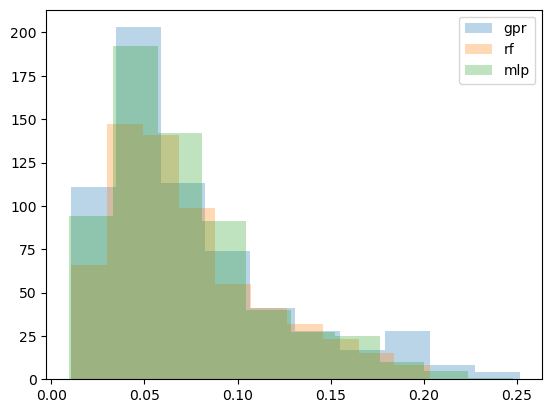

In [25]:
# this means combining gpr + rf is always better than ann

gpr_rmse_m = np.nanmean(gpr_rmse_test, axis=1)
rf_rmse_m = np.nanmean(rf_rmse_test, axis=1)
mlp_rmse_m = np.nanmean(mlp_rmse_test, axis=1)

ind = (gpr_rmse_m<mlp_rmse_m) | (rf_rmse_m<mlp_rmse_m)
print('ratio that gpr+rf is better than mlp', np.sum(ind)/numbasin)
print('ratio gpr is better than rf', np.sum(gpr_rmse_m < rf_rmse_m)/numbasin)
print('ratio gpr is better than mlp', np.sum(gpr_rmse_m < mlp_rmse_m)/numbasin)
print('ratio rf is better than mlp', np.sum(rf_rmse_m < mlp_rmse_m)/numbasin)

gpr_rmse_m = np.nanmean(gpr_rmse_test, axis=1)
rf_rmse_m = np.nanmean(rf_rmse_test, axis=1)
mlp_rmse_m = np.nanmean(mlp_rmse_test, axis=1)

plt.hist(gpr_rmse_m, alpha=0.3, label='gpr')
plt.hist(rf_rmse_m, alpha=0.3, label='rf')
plt.hist(mlp_rmse_m, alpha=0.3, label='mlp')
plt.legend()
plt.show()